In [3]:
import sys

sys.path.append("/Users/leo/Desktop/Thesis/utils/")
sys.path.append("/Users/leo/Desktop/Thesis/models/")

import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision.models import mobilenet_v3_large, mobilenet_v3_small
from torchvision.models import MobileNet_V3_Large_Weights as weights_large, MobileNet_V3_Small_Weights as weights_small
import torchvision.transforms as transforms
from torchinfo import summary
from helper_functions import delete_ds_store, plot_metrics, test, train, set_device, mean_std_finder, load_model
from CBAM import _CBAM
from MBNV3_2 import MBNV3Creator
from config import comet_token, project_name, workspace
from comet_ml import Experiment

#setting the seed for reproducibility
torch.manual_seed(42)

In [4]:
prms = {
    "backbone": mobilenet_v3_large,
    "weights": weights_large.IMAGENET1K_V1,
    "module": _CBAM,
    "module_alias": "CBAM",
    "data_path": "../data/faces_50/",
    "batch_size": 16,
    "img_size": 224,
    "num_classes": 50,
    "epochs": 5,
    "learning_rate": 0.001,
    "device": set_device(),
    "model": None,
    "experiment": None,
    "load_model": False,
}
prms["model_save_path"] = f"./output/{prms['module_alias']}_{prms['data_path'].split('/')[-2]}.pth"

model = prms["model"] = MBNV3Creator(prms["backbone"], prms["num_classes"], prms["weights"], prms["device"], prms["module"])
delete_ds_store(prms["data_path"])

In [5]:
#mean, std = mean_std_finder(prms["data_path"])
mean, std = torch.tensor([0.3860, 0.3119, 0.2690]), torch.tensor([0.2279, 0.2167, 0.2135])

train_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [6]:
#Accessing the data
train_data = torchvision.datasets.ImageFolder(prms["data_path"] + "train/", transform=train_transform)
val_data = torchvision.datasets.ImageFolder(prms["data_path"] + "val/", transform=test_transform)
test_data = torchvision.datasets.ImageFolder(prms["data_path"] + "test/", transform=test_transform)

#Creating the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False, num_workers=0)

In [ ]:
#display random images from the dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #drop axis labels
    plt.axis('off')
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [24]:
#build the model

model = load_model(model.build(), prms["model_save_path"]) if prms["load_model"] else model.build()

# Loss and optimizer
criterion = nn.CrossEntropyLoss().to(prms["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=prms["learning_rate"])

# log loss and optimizer
prms["experiment"].log_parameters({"loss": criterion, "optimizer": optimizer}) if prms["experiment"] else None

SE layers: [4, 5, 6, 11, 12, 13, 14, 15]
<class 'CBAM._CBAM'> inserted in the following layers: [4, 5, 6, 11, 12, 13, 14, 15]
Weights initialized for <class 'CBAM._CBAM'> inserted in the following layers: [4, 5, 6, 11, 12, 13, 14, 15] as well as the last layer.
Grads set to True for [4, 5, 6, 11, 12, 13, 14, 15] and the last layer. (False for the rest)


In [25]:
model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [ ]:
summary(model, input_size=(1, 3, prms["img_size"], prms["img_size"]),
        col_names = ["input_size", "output_size", "num_params", "kernel_size", "mult_adds", "trainable"],
        col_width = 20,
        row_settings = ["var_names"],
        depth=8)

In [ ]:
#train the model
train_losses, train_acc, val_losses, val_acc = train(model, train_loader, val_loader, criterion, optimizer, hyper_params = prms, verbose = 2, experiment = prms["experiment"])

#plot the training and validation metrics
plot_metrics(train_losses, train_acc, val_losses, val_acc)

In [ ]:
#test the model
test(model, test_loader, criterion, hyper_params = prms, experiment = prms["experiment"])

In [26]:
from torchvision.models import mobilenet_v3_small, mobilenet_v3_large
from torchvision.models import MobileNet_V3_Small_Weights as small_weights, MobileNet_V3_Large_Weights as large_weights
import torch.nn.functional as F


class MBNV3_Grad(nn.Module):
    def __init__(self, model, module, output_size):
        super(MBNV3_Grad, self).__init__()

        self.model = model
        self.module = module
        self.output_size = output_size
        self.layers = [1, 4, 5, 6, 7, 8, 9, 10, 11] if self.model == "small" else [4, 5, 6, 11, 12, 13, 14, 15]

    # Initialize the weights of the inserted module layers or the SE block
    def _weights_init(self, m):
        torch.manual_seed(42)
        if isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            n = m.weight.size(1)
            m.weight.data.normal_(0, 0.01)

    def set_grad(self):
        """_summary_: This function is used to set the gradient of the inserted module layers or the SE block.
        """
        #set all grads in the model to false
        for param in self.mbnv3.parameters():
            param.requires_grad = False

        #set the grad of the last layer to true
        for param in self.mbnv3.classifier[-1].parameters():
            param.requires_grad = True

        if self.model == "small":
            for param in self.mbnv3.features[1].block[1].parameters():
                param.requires_grad = True

            for i in self.layers[1:]:
                for param in self.mbnv3.features[i].block[2].parameters():
                    param.requires_grad = True
        else:
            for i in self.layers:
                for param in self.mbnv3.features[i].block[2].parameters():
                    param.requires_grad = True


        return self.mbnv3

    def create_custom_model(self):
        """_summary_: This function is used to create a custom model by inserting the custom module """
        if self.model == "small":
            # setting the base model
            self.mbnv3 = mobilenet_v3_small(weights= small_weights.IMAGENET1K_V1)
            # setting the custom module in specific layers for small variant
            if self.model == "small" and self.layers[0] == 1:
                prev_out_channels = self.mbnv3.features[1].block[0].out_channels
                self.mbnv3.features[1].block[1] = self.module(prev_out_channels) if self.module != None else self.mbnv3.features[1].block[1]
                self.mbnv3.features[1].block[1].apply(self._weights_init)

            for i in self.layers[1:]:
                prev_out_channels = self.mbnv3.features[i].block[0].out_channels
                self.mbnv3.features[i].block[2] = self.module(prev_out_channels) if self.module != None else self.mbnv3.features[i].block[2]
                self.mbnv3.features[i].block[2].apply(self._weights_init)
        else:
            # setting the base model in specific layers for large variant
            self.mbnv3 = mobilenet_v3_large(weights= large_weights.DEFAULT)
            for i in self.layers:
                prev_out_channels = self.mbnv3.features[i].block[0].out_channels
                self.mbnv3.features[i].block[2] = self.module(prev_out_channels) if self.module != None else self.mbnv3.features[i].block[2]
                self.mbnv3.features[i].block[2].apply(self._weights_init)

        self.mbnv3.classifier[-1] = nn.Linear(self.mbnv3.classifier[-1].in_features, self.output_size)
        self.mbnv3.classifier[-1].apply(self._weights_init)

        self.set_grad()

        return self.mbnv3

    def restructure_model(self):
        # dissect the network to access its last convolutional layer
        self.features_conv = self.mbnv3.features[:13] if self.model == "small" else self.mbnv3.features[:17]  
        # adaptive average pooling
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=1)  
        # get the classifier of the model
        self.classifier = self.mbnv3.classifier
        # placeholder for the gradients
        self.gradients = None

        # delete the original model
        del self.mbnv3

        return self.features_conv, self.avgpool, self.classifier
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        
        self.create_custom_model() # create the custom model
        self.restructure_model() # restructure the model
        
        x = self.features_conv(x) # extract the features

        # register the hook
        #set the last tensor to have requires_grad = True
        h = x.register_hook(self.activations_hook) # register the hook
    
        # adaptively average pool the features
        x = self.avgpool(x) # adaptive average pooling

        x = x.squeeze() # flatten the output of the adaptive average pooling
        x = self.classifier(x) # get the class probabilities from the classifier

        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

In [32]:
model_grad = MBNV3_Grad("large", None, 50)
model_grad

MBNV3_Grad()

In [23]:
#load the state dict
model_grad.load_state_dict(torch.load("/Users/leo/Desktop/Thesis/notebooks/output/CBAM_faces_50.pth"))

model.eval()

img, _ = test_data[0]

img = img.unsqueeze(0)

pred = model_grad(img)

argmax = pred[0].argmax()

print(argmax)


RuntimeError: Error(s) in loading state_dict for MBNV3_Grad:
	Unexpected key(s) in state_dict: "features_conv.0.0.weight", "features_conv.0.1.weight", "features_conv.0.1.bias", "features_conv.0.1.running_mean", "features_conv.0.1.running_var", "features_conv.0.1.num_batches_tracked", "features_conv.1.block.0.0.weight", "features_conv.1.block.0.1.weight", "features_conv.1.block.0.1.bias", "features_conv.1.block.0.1.running_mean", "features_conv.1.block.0.1.running_var", "features_conv.1.block.0.1.num_batches_tracked", "features_conv.1.block.1.0.weight", "features_conv.1.block.1.1.weight", "features_conv.1.block.1.1.bias", "features_conv.1.block.1.1.running_mean", "features_conv.1.block.1.1.running_var", "features_conv.1.block.1.1.num_batches_tracked", "features_conv.2.block.0.0.weight", "features_conv.2.block.0.1.weight", "features_conv.2.block.0.1.bias", "features_conv.2.block.0.1.running_mean", "features_conv.2.block.0.1.running_var", "features_conv.2.block.0.1.num_batches_tracked", "features_conv.2.block.1.0.weight", "features_conv.2.block.1.1.weight", "features_conv.2.block.1.1.bias", "features_conv.2.block.1.1.running_mean", "features_conv.2.block.1.1.running_var", "features_conv.2.block.1.1.num_batches_tracked", "features_conv.2.block.2.0.weight", "features_conv.2.block.2.1.weight", "features_conv.2.block.2.1.bias", "features_conv.2.block.2.1.running_mean", "features_conv.2.block.2.1.running_var", "features_conv.2.block.2.1.num_batches_tracked", "features_conv.3.block.0.0.weight", "features_conv.3.block.0.1.weight", "features_conv.3.block.0.1.bias", "features_conv.3.block.0.1.running_mean", "features_conv.3.block.0.1.running_var", "features_conv.3.block.0.1.num_batches_tracked", "features_conv.3.block.1.0.weight", "features_conv.3.block.1.1.weight", "features_conv.3.block.1.1.bias", "features_conv.3.block.1.1.running_mean", "features_conv.3.block.1.1.running_var", "features_conv.3.block.1.1.num_batches_tracked", "features_conv.3.block.2.0.weight", "features_conv.3.block.2.1.weight", "features_conv.3.block.2.1.bias", "features_conv.3.block.2.1.running_mean", "features_conv.3.block.2.1.running_var", "features_conv.3.block.2.1.num_batches_tracked", "features_conv.4.block.0.0.weight", "features_conv.4.block.0.1.weight", "features_conv.4.block.0.1.bias", "features_conv.4.block.0.1.running_mean", "features_conv.4.block.0.1.running_var", "features_conv.4.block.0.1.num_batches_tracked", "features_conv.4.block.1.0.weight", "features_conv.4.block.1.1.weight", "features_conv.4.block.1.1.bias", "features_conv.4.block.1.1.running_mean", "features_conv.4.block.1.1.running_var", "features_conv.4.block.1.1.num_batches_tracked", "features_conv.4.block.2.fc1.weight", "features_conv.4.block.2.fc1.bias", "features_conv.4.block.2.fc2.weight", "features_conv.4.block.2.fc2.bias", "features_conv.4.block.3.0.weight", "features_conv.4.block.3.1.weight", "features_conv.4.block.3.1.bias", "features_conv.4.block.3.1.running_mean", "features_conv.4.block.3.1.running_var", "features_conv.4.block.3.1.num_batches_tracked", "features_conv.5.block.0.0.weight", "features_conv.5.block.0.1.weight", "features_conv.5.block.0.1.bias", "features_conv.5.block.0.1.running_mean", "features_conv.5.block.0.1.running_var", "features_conv.5.block.0.1.num_batches_tracked", "features_conv.5.block.1.0.weight", "features_conv.5.block.1.1.weight", "features_conv.5.block.1.1.bias", "features_conv.5.block.1.1.running_mean", "features_conv.5.block.1.1.running_var", "features_conv.5.block.1.1.num_batches_tracked", "features_conv.5.block.2.fc1.weight", "features_conv.5.block.2.fc1.bias", "features_conv.5.block.2.fc2.weight", "features_conv.5.block.2.fc2.bias", "features_conv.5.block.3.0.weight", "features_conv.5.block.3.1.weight", "features_conv.5.block.3.1.bias", "features_conv.5.block.3.1.running_mean", "features_conv.5.block.3.1.running_var", "features_conv.5.block.3.1.num_batches_tracked", "features_conv.6.block.0.0.weight", "features_conv.6.block.0.1.weight", "features_conv.6.block.0.1.bias", "features_conv.6.block.0.1.running_mean", "features_conv.6.block.0.1.running_var", "features_conv.6.block.0.1.num_batches_tracked", "features_conv.6.block.1.0.weight", "features_conv.6.block.1.1.weight", "features_conv.6.block.1.1.bias", "features_conv.6.block.1.1.running_mean", "features_conv.6.block.1.1.running_var", "features_conv.6.block.1.1.num_batches_tracked", "features_conv.6.block.2.fc1.weight", "features_conv.6.block.2.fc1.bias", "features_conv.6.block.2.fc2.weight", "features_conv.6.block.2.fc2.bias", "features_conv.6.block.3.0.weight", "features_conv.6.block.3.1.weight", "features_conv.6.block.3.1.bias", "features_conv.6.block.3.1.running_mean", "features_conv.6.block.3.1.running_var", "features_conv.6.block.3.1.num_batches_tracked", "features_conv.7.block.0.0.weight", "features_conv.7.block.0.1.weight", "features_conv.7.block.0.1.bias", "features_conv.7.block.0.1.running_mean", "features_conv.7.block.0.1.running_var", "features_conv.7.block.0.1.num_batches_tracked", "features_conv.7.block.1.0.weight", "features_conv.7.block.1.1.weight", "features_conv.7.block.1.1.bias", "features_conv.7.block.1.1.running_mean", "features_conv.7.block.1.1.running_var", "features_conv.7.block.1.1.num_batches_tracked", "features_conv.7.block.2.0.weight", "features_conv.7.block.2.1.weight", "features_conv.7.block.2.1.bias", "features_conv.7.block.2.1.running_mean", "features_conv.7.block.2.1.running_var", "features_conv.7.block.2.1.num_batches_tracked", "features_conv.8.block.0.0.weight", "features_conv.8.block.0.1.weight", "features_conv.8.block.0.1.bias", "features_conv.8.block.0.1.running_mean", "features_conv.8.block.0.1.running_var", "features_conv.8.block.0.1.num_batches_tracked", "features_conv.8.block.1.0.weight", "features_conv.8.block.1.1.weight", "features_conv.8.block.1.1.bias", "features_conv.8.block.1.1.running_mean", "features_conv.8.block.1.1.running_var", "features_conv.8.block.1.1.num_batches_tracked", "features_conv.8.block.2.0.weight", "features_conv.8.block.2.1.weight", "features_conv.8.block.2.1.bias", "features_conv.8.block.2.1.running_mean", "features_conv.8.block.2.1.running_var", "features_conv.8.block.2.1.num_batches_tracked", "features_conv.9.block.0.0.weight", "features_conv.9.block.0.1.weight", "features_conv.9.block.0.1.bias", "features_conv.9.block.0.1.running_mean", "features_conv.9.block.0.1.running_var", "features_conv.9.block.0.1.num_batches_tracked", "features_conv.9.block.1.0.weight", "features_conv.9.block.1.1.weight", "features_conv.9.block.1.1.bias", "features_conv.9.block.1.1.running_mean", "features_conv.9.block.1.1.running_var", "features_conv.9.block.1.1.num_batches_tracked", "features_conv.9.block.2.0.weight", "features_conv.9.block.2.1.weight", "features_conv.9.block.2.1.bias", "features_conv.9.block.2.1.running_mean", "features_conv.9.block.2.1.running_var", "features_conv.9.block.2.1.num_batches_tracked", "features_conv.10.block.0.0.weight", "features_conv.10.block.0.1.weight", "features_conv.10.block.0.1.bias", "features_conv.10.block.0.1.running_mean", "features_conv.10.block.0.1.running_var", "features_conv.10.block.0.1.num_batches_tracked", "features_conv.10.block.1.0.weight", "features_conv.10.block.1.1.weight", "features_conv.10.block.1.1.bias", "features_conv.10.block.1.1.running_mean", "features_conv.10.block.1.1.running_var", "features_conv.10.block.1.1.num_batches_tracked", "features_conv.10.block.2.0.weight", "features_conv.10.block.2.1.weight", "features_conv.10.block.2.1.bias", "features_conv.10.block.2.1.running_mean", "features_conv.10.block.2.1.running_var", "features_conv.10.block.2.1.num_batches_tracked", "features_conv.11.block.0.0.weight", "features_conv.11.block.0.1.weight", "features_conv.11.block.0.1.bias", "features_conv.11.block.0.1.running_mean", "features_conv.11.block.0.1.running_var", "features_conv.11.block.0.1.num_batches_tracked", "features_conv.11.block.1.0.weight", "features_conv.11.block.1.1.weight", "features_conv.11.block.1.1.bias", "features_conv.11.block.1.1.running_mean", "features_conv.11.block.1.1.running_var", "features_conv.11.block.1.1.num_batches_tracked", "features_conv.11.block.2.fc1.weight", "features_conv.11.block.2.fc1.bias", "features_conv.11.block.2.fc2.weight", "features_conv.11.block.2.fc2.bias", "features_conv.11.block.3.0.weight", "features_conv.11.block.3.1.weight", "features_conv.11.block.3.1.bias", "features_conv.11.block.3.1.running_mean", "features_conv.11.block.3.1.running_var", "features_conv.11.block.3.1.num_batches_tracked", "features_conv.12.block.0.0.weight", "features_conv.12.block.0.1.weight", "features_conv.12.block.0.1.bias", "features_conv.12.block.0.1.running_mean", "features_conv.12.block.0.1.running_var", "features_conv.12.block.0.1.num_batches_tracked", "features_conv.12.block.1.0.weight", "features_conv.12.block.1.1.weight", "features_conv.12.block.1.1.bias", "features_conv.12.block.1.1.running_mean", "features_conv.12.block.1.1.running_var", "features_conv.12.block.1.1.num_batches_tracked", "features_conv.12.block.2.fc1.weight", "features_conv.12.block.2.fc1.bias", "features_conv.12.block.2.fc2.weight", "features_conv.12.block.2.fc2.bias", "features_conv.12.block.3.0.weight", "features_conv.12.block.3.1.weight", "features_conv.12.block.3.1.bias", "features_conv.12.block.3.1.running_mean", "features_conv.12.block.3.1.running_var", "features_conv.12.block.3.1.num_batches_tracked", "features_conv.13.block.0.0.weight", "features_conv.13.block.0.1.weight", "features_conv.13.block.0.1.bias", "features_conv.13.block.0.1.running_mean", "features_conv.13.block.0.1.running_var", "features_conv.13.block.0.1.num_batches_tracked", "features_conv.13.block.1.0.weight", "features_conv.13.block.1.1.weight", "features_conv.13.block.1.1.bias", "features_conv.13.block.1.1.running_mean", "features_conv.13.block.1.1.running_var", "features_conv.13.block.1.1.num_batches_tracked", "features_conv.13.block.2.fc1.weight", "features_conv.13.block.2.fc1.bias", "features_conv.13.block.2.fc2.weight", "features_conv.13.block.2.fc2.bias", "features_conv.13.block.3.0.weight", "features_conv.13.block.3.1.weight", "features_conv.13.block.3.1.bias", "features_conv.13.block.3.1.running_mean", "features_conv.13.block.3.1.running_var", "features_conv.13.block.3.1.num_batches_tracked", "features_conv.14.block.0.0.weight", "features_conv.14.block.0.1.weight", "features_conv.14.block.0.1.bias", "features_conv.14.block.0.1.running_mean", "features_conv.14.block.0.1.running_var", "features_conv.14.block.0.1.num_batches_tracked", "features_conv.14.block.1.0.weight", "features_conv.14.block.1.1.weight", "features_conv.14.block.1.1.bias", "features_conv.14.block.1.1.running_mean", "features_conv.14.block.1.1.running_var", "features_conv.14.block.1.1.num_batches_tracked", "features_conv.14.block.2.fc1.weight", "features_conv.14.block.2.fc1.bias", "features_conv.14.block.2.fc2.weight", "features_conv.14.block.2.fc2.bias", "features_conv.14.block.3.0.weight", "features_conv.14.block.3.1.weight", "features_conv.14.block.3.1.bias", "features_conv.14.block.3.1.running_mean", "features_conv.14.block.3.1.running_var", "features_conv.14.block.3.1.num_batches_tracked", "features_conv.15.block.0.0.weight", "features_conv.15.block.0.1.weight", "features_conv.15.block.0.1.bias", "features_conv.15.block.0.1.running_mean", "features_conv.15.block.0.1.running_var", "features_conv.15.block.0.1.num_batches_tracked", "features_conv.15.block.1.0.weight", "features_conv.15.block.1.1.weight", "features_conv.15.block.1.1.bias", "features_conv.15.block.1.1.running_mean", "features_conv.15.block.1.1.running_var", "features_conv.15.block.1.1.num_batches_tracked", "features_conv.15.block.2.fc1.weight", "features_conv.15.block.2.fc1.bias", "features_conv.15.block.2.fc2.weight", "features_conv.15.block.2.fc2.bias", "features_conv.15.block.3.0.weight", "features_conv.15.block.3.1.weight", "features_conv.15.block.3.1.bias", "features_conv.15.block.3.1.running_mean", "features_conv.15.block.3.1.running_var", "features_conv.15.block.3.1.num_batches_tracked", "features_conv.16.0.weight", "features_conv.16.1.weight", "features_conv.16.1.bias", "features_conv.16.1.running_mean", "features_conv.16.1.running_var", "features_conv.16.1.num_batches_tracked", "classifier.0.weight", "classifier.0.bias", "classifier.3.weight", "classifier.3.bias". 

1. gradients.shape: torch.Size([1, 960, 7, 7])
2. pooled_gradients.shape: torch.Size([960])
3. activations.shape: torch.Size([1, 960, 7, 7])
4. activations.shape: torch.Size([1, 960, 7, 7])
5. heatmap.shape: torch.Size([7, 7])


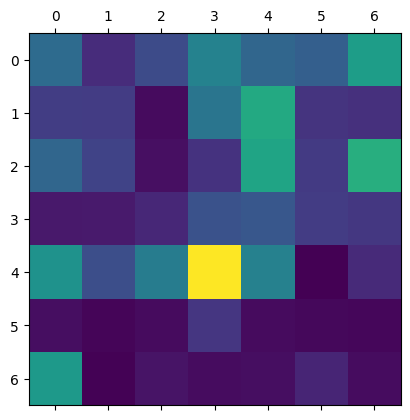

In [19]:
# get the gradient of the output with respect to the parameters of the model
pred[argmax].backward()
# pull the gradients out of the model
gradients = model_grad.get_activations_gradient()
print(f"1. gradients.shape: {gradients.shape}")

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
print(f"2. pooled_gradients.shape: {pooled_gradients.shape}")

# get the activations of the last convolutional layer
activations = model_grad.get_activations(img).detach()
print(f"3. activations.shape: {activations.shape}")

# weight the channels by corresponding gradients
for i in range(576):
    activations[:, i, :, :] *= pooled_gradients[i]

print(f"4. activations.shape: {activations.shape}")
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

#convert to numpy
heatmap = torch.maximum(heatmap, torch.tensor(0.))
print(f"5. heatmap.shape: {heatmap.shape}")

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

In [20]:
import cv2
import numpy as np

img = img.squeeze().numpy().transpose(1,2,0)


# transform both the image and the heatmap to numpy
heatmap = heatmap.numpy()

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./map.jpg', superimposed_img)

True

In [21]:
import numpy as np
from PIL import Image

def array_to_image(arr):
    # Scale the pixel values from [0, 1] to [0, 255]
    arr = (255 * arr).astype(np.uint8)
    # Create a PIL image from the array
    img = Image.fromarray(arr)
    return img

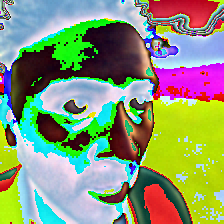

In [22]:
array_to_image(img)